In [147]:
NOTEBOOK_NAME = 'model.ipynb'

In [1]:
import os
import tqdm
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn
import torchvision as tv

from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torchvision import datasets, transforms

from utils import save_pickle, load_pickle, ImageSearcher

In [14]:
EXP_NAME = 'efficientnet'
ARTIFCAT_PATH = os.path.join(EXP_NAME, 'artifacts')
os.makedirs(ARTIFCAT_PATH, exist_ok=True)

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

In [3]:
searcher = ImageSearcher('train')

## Dataset

In [4]:
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        files = os.listdir(self.folder)
        self.labels = ['.'.join(e.split('.')[:-1]) for e in files]
        self.files = [os.path.join(folder, f) for f in files]
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image_path = self.files[idx]
        image = tv.io.read_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return (image, label)

In [21]:
IMAGE_SIZE = 480


ds_train = ImageLoader(
    folder='torch_data/train',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

ds_val = ImageLoader(
    folder='torch_data/val',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

In [30]:
train_loader = torch.utils.data.DataLoader(
    ds_train,
    64,
)

val_loader = torch.utils.data.DataLoader(
    ds_val,
    64,
)

## Model

In [7]:
model = efficientnet.efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Identity()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
model = model.to(device)

## Embeddings

In [23]:
def collect_preds(module, loader):
    x_all = []
    y_all = []
    for x, y in tqdm.tqdm(loader):
        with torch.no_grad():
            x = model(x.to(device)).cpu().numpy()
            x_all.append(x)
            y_all.append(y)
            
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    
    return x_all, y_all

### computing embeddings

In [24]:
x_train, y_train = collect_preds(model, train_loader)
x_val, y_val = collect_preds(model, val_loader)

100%|██████████| 109/109 [05:19<00:00,  2.93s/it]


In [34]:
save_pickle([x_train, y_train], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
save_pickle([x_val, y_val], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

# Model

In [150]:
import pandas as pd
from utils import load_pickle
from sklearn.metrics import mean_squared_error
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from tqdm.notebook import tqdm
import shutil

In [49]:
def prepare_data(x, y, meta_all):
    y = meta_all.set_index('Id').loc[y]['Pawpularity'].to_numpy()
    y = y / 100
    
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    return x, y

In [ ]:
meta_all = pd.read_csv('train.csv')

In [376]:
x_train, y_train = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
x_val, y_val = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

x_train, y_train = prepare_data(x_train, y_train, meta_all)
x_val, y_val = prepare_data(x_val, y_val, meta_all)

In [ ]:
from sklearn.decomposition import PCA

projector = PCA(512)
x_train = projector.fit_transform(x_train)
x_val = projector.fit_transform(x_val)

In [ ]:
1

In [361]:
EMB_SIZE = x_train.shape[1]

In [362]:
rmse = lambda yh, y: mean_squared_error(y, yh) ** 0.5

In [363]:
def l1_reg(module: nn.Module):
    flat_weights = torch.cat([e.view(-1) for e in module.parameters()])
    flat_weights = torch.abs(flat_weights)
    loss = torch.sum(flat_weights)
    
    return loss

In [364]:
class PawpularityEmbeddingsDataset(data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        
        self.x = x
        self.y = y[:, np.newaxis]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [365]:
class PawpularityHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, 1)
        self.fc_act = nn.Sigmoid() # for test simplicity
        
    def forward(self, x):
        x = self.fc(x)
        x = self.fc_act(x)
        
        return x

In [366]:
def test(module, test_dl, metrics:dict):
    module = module.train(False)
    
    yh = []
    yt = []
    with torch.no_grad():
        for x, y in test_dl:
            yhc = module(x).detach().cpu().numpy()
            yh.append(yhc)
            yt.append(y)
            
    yh = np.concatenate(yh, axis=0)
    y = np.concatenate(yt, axis=0)
    
    res = {}
    for mname, mfunc in metrics.items():
        res[mname] = mfunc(yh, y)
    
    return res

In [367]:
def train(
    module: nn.Module, 
    loss_f, 
    optimizer: torch.optim.Optimizer, 
    train_dl: data.DataLoader, 
    test_dl: data.DataLoader, 
    epochs: int,
    loss_alpha=0.01,
    pbar_update_steps: int=100,
    ):
    
    logs = []
    test_logs = []
    for epoch in range(epochs):
        module = module.train(True)
        with tqdm(total=len(train_dl)) as pbar:
            pbar.set_description(f'epoch {epoch}')
            
            for step, (x, y) in enumerate(train_dl):
                yh = module(x)
                loss = loss_f(yh, y)
#                 loss_reg = l1_reg(module)
                
#                 loss_full = loss + loss_alpha * loss_reg
                loss_full = loss
    
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                
                loss = loss.detach().cpu().numpy()
#                 loss_reg = loss_reg.detach().cpu().numpy()
                
                log = {
                    'loss' : float(loss), 
#                     'loss_reg': float(loss_reg),
                    'rmse': rmse(yh.detach().cpu().numpy(), y.detach().cpu().numpy()),
                }
                logs.append(log)
                
                if step % pbar_update_steps == 0:
                    running_loss = np.mean([log['loss'] for log in logs[-pbar_update_steps:]])
                    pbar.set_postfix({'loss' : running_loss})
                pbar.update()
        
        test_metrics = test(module, test_dl, {'rmse' : rmse})
        test_logs.append(test_metrics)
        print(test_metrics)
    
    return logs, test_logs

In [368]:
METRIC_COLLECTION_STEPS = 100
SUB_EXP_NAME = 'dim_reduction'
SUB_EXP_ARTIFACTS = os.path.join(ARTIFCAT_PATH, SUB_EXP_NAME)
os.makedirs(SUB_EXP_ARTIFACTS, exist_ok=True)

In [369]:
model = PawpularityHead(EMB_SIZE)
embs_dataset_train = PawpularityEmbeddingsDataset(x_train, y_train)
embs_dataset_val = PawpularityEmbeddingsDataset(x_val, y_val)

loader_train = data.DataLoader(embs_dataset_train, 64)
loader_val = data.DataLoader(embs_dataset_val, 64)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logs, test_logs = train(
    model, 
    loss_fn, 
    optimizer, 
    loader_train, 
    loader_val, 
    epochs=20, 
#     loss_alpha=0.001,
    pbar_update_steps=METRIC_COLLECTION_STEPS)

  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2195606283303006}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.21258374064807858}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20943584874582796}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2079153527022094}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20737141428233619}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20737515083109756}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2076382196634268}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20798898889322912}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2083380768156452}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2086465458009477}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2089027263113074}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20910787943778592}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.2092685015826834}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20939241664243224}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20948704312232194}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20955883823066007}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20961306829962956}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20965391377574424}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20968463371296256}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20970773732841996}


In [370]:
logs[0]

{'loss': 0.704971194267273, 'rmse': 0.26365418551410913}

In [371]:
save_pickle(logs, os.path.join(SUB_EXP_ARTIFACTS, 'train_logs.pkl'))
save_pickle(test_logs, os.path.join(SUB_EXP_ARTIFACTS, 'test_logs.pkl'))
save_pickle(model.state_dict(), os.path.join(SUB_EXP_ARTIFACTS, 'state_dict.pkl'))

In [372]:
round(test_logs[-1]['rmse'], 4)

0.2097

In [373]:
train_logs_df = pd.DataFrame(logs)

test_logs_df = pd.DataFrame(test_logs)
test_logs_df.index = test_logs_df.index * METRIC_COLLECTION_STEPS + METRIC_COLLECTION_STEPS

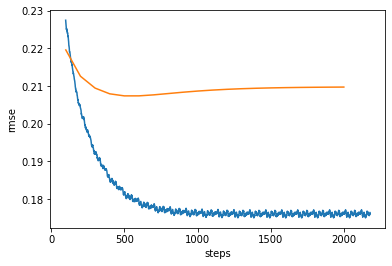

In [374]:
plt.xlabel('steps')
plt.ylabel('rmse')
train_logs_df['rmse'].rolling(METRIC_COLLECTION_STEPS).mean().plot()
test_logs_df['rmse'].plot()
plt.savefig(os.path.join(SUB_EXP_ARTIFACTS, 'rmse_plot.png'))

In [345]:
np.sum(np.abs(model.fc.weight.detach().cpu().numpy()[0]) < 1e-5)

1

(array([ 10.,  22.,  81., 138., 146.,  68.,  36.,   8.,   2.,   1.]),
 array([-0.1030893 , -0.07744635, -0.0518034 , -0.02616044, -0.00051749,
         0.02512547,  0.05076842,  0.07641137,  0.10205433,  0.12769729,
         0.15334024], dtype=float32),
 <BarContainer object of 10 artists>)

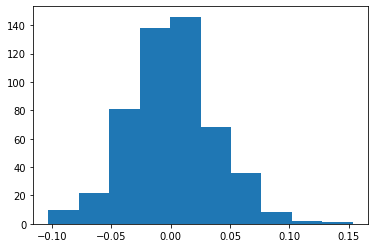

In [336]:
plt.hist(model.fc.weight.detach().cpu().numpy()[0])

In [190]:
shutil.copyfile(NOTEBOOK_NAME, os.path.join(SUB_EXP_ARTIFACTS, 'model.ipynb'))

'efficientnet/artifacts/l2_regularization/model.ipynb'